In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Import

In [2]:
import pandas
import numexpr
import numpy
from rep_ef.estimators import MatrixNetSkyGridClassifier
from rep.metaml import FoldingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
%run utils.py

## Reading initial data

In [4]:
data_nan = pandas.read_csv('../../datasets/Tagging/Tracks.csv', sep='\t')

In [5]:
data_nan.head()

,run,event,Bmass,i,mult,partP,partPt,ptB,IPs,IP,...,eta,proj,ID,veloch,signB,signTrack,N_sig_sw,mu_cut,e_cut,K_cut
0,115839,204997902,5.309576,0,13,3.67156,0.300418,4.004197,0.816143,0.056365,...,3.194668,1.058442,-211,0.911645,1,-1,0.59521,0,0,0
1,115839,204997902,5.309576,1,13,8.33952,1.103876,4.004197,1.375382,0.033095,...,2.710916,3.121358,-211,0.796731,1,-1,0.59521,0,0,0
2,115839,204997902,5.309576,2,13,8.37654,1.182519,4.004197,4.338812,0.077636,...,2.645916,10.585135,-211,0.946629,1,-1,0.59521,0,0,0
3,115839,204997902,5.309576,3,13,25.72961,0.905010,4.004197,2.287509,0.086603,...,4.040289,7.485243,211,1.058989,1,1,0.59521,0,0,0
4,115839,204997902,5.309576,4,13,3.70597,0.516123,4.004197,0.562424,0.015694,...,2.659618,5.617354,211,1.042135,1,1,0.59521,0,0,0


In [6]:
statistics(data_nan)

{'Events': 1005579, 'tracks': 27156193}

In [7]:
N_all = sum([gr['N_sig_sw'].values[0] for _, gr in data_nan.groupby('event')])

In [8]:
N_all

742632.88650423975

## Remove NAN data

In [9]:
data = data_nan.dropna()
len(data_nan), len(data), statistics(data)

(27156193, 27156190, {'Events': 1005579, 'tracks': 27156190})

## Add diff_pt and cos(diff_phi)

In [10]:
# add different between max pt in event and pt for each track
def add_diff_pt(data):
    data['diff_pt'] = 0.
    max_pt = group_max(data.event.values.astype(numpy.int64), data.partPt.values)
    data['diff_pt'] = max_pt - data['partPt'].values

# max is very similar
def group_max(groups, data):
    print len(groups), len(data)
    order = numpy.lexsort((data, groups))
    _, _groups = numpy.unique(groups, return_inverse=True)
    groups = groups[order] #this is only needed if groups is unsorted
    data = data[order]
    index = numpy.empty(len(groups), 'bool')
    index[-1] = True
    index[:-1] = groups[1:] != groups[:-1]
    return data[index][_groups]

In [11]:
# add diff pt
add_diff_pt(data)
# add cos(diff_phi)
data['cos_diff_phi'] = numpy.cos(data.diff_phi.values)

27156190 27156190


/mnt/mfs/ipython_env/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


## define `label` = `signB` * `signTrack`

* if > 0 (same sign) - label **1**
* if < 0 (different sign) - label **0**

In [12]:
data['label'] = (data.signB.values * data.signTrack.values > 0) * 1

## Select protons and pions, ghost prob cut

In [13]:
threshold_mistag = 0.6
initial_cut = '(PIDNNp < {tr}) & (PIDNNpi < {tr}) & (ghostProb < 0.4)'.format(tr=threshold_mistag)
data = data.query(initial_cut)

## Select muons, kaons, electrons

In [14]:
threshold_kaon = 0.7 
threshold_muon = 0.4
threshold_electron = 0.6
cut_pid = """
            ((PIDNNk > {trk}) 
                | (PIDNNm > {trm}) 
                | (PIDNNe > {tre})) """.format(trk=threshold_kaon, trm=threshold_muon,
                                               tre=threshold_electron).replace("\n", "")
    
data = data.query(cut_pid)

In [15]:
statistics(data)

{'Events': 657792, 'tracks': 1191986}

## $\epsilon_{tag}$ calculation

$$N (\text{passed selection}) = \sum_{\text{passed selection}} sw_i$$

$$N (\text{all events}) = \sum_{\text{all events}} sw_i,$$

where $sw_i$ - sPLot weight

$$\epsilon_{tag} = \frac{N (\text{passed selection})} {N (\text{all events})}$$

$$\Delta\epsilon_{tag} = \frac{\sqrt{N (\text{passed selection})}} {N (\text{all events})}$$

In [16]:
N_pass = sum([gr['N_sig_sw'].values[0] for _, gr in data.groupby('event')])
eff_tag = 1. * N_pass / N_all
eff_delta = sqrt(N_pass) / N_all
eff_tag, eff_delta

(0.66960761484584619, 0.00094956151174887388)

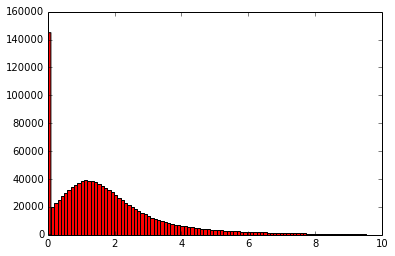

In [17]:
hist(data.diff_pt.values, bins=100)
pass

## Choose most probable B-events

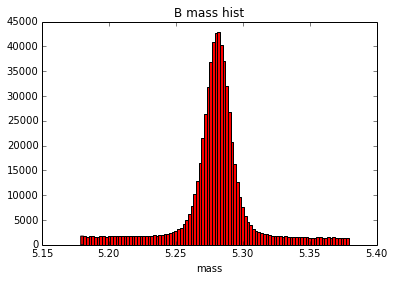

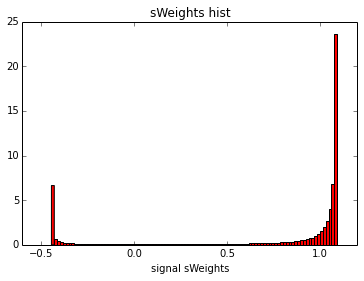

In [18]:
hist([gr['Bmass'].values[0] for _, gr in data.groupby('event')], bins=100)
title('B mass hist')
xlabel('mass')
show()
hist([gr['N_sig_sw'].values[0] for _, gr in data.groupby('event')], bins=100, normed=True)
title('sWeights hist')
xlabel('signal sWeights')
pass

### define B-like events for training and others for prediction

In [19]:
sweight_threshold = 1.
data_sw_pass = data[data.N_sig_sw > sweight_threshold]
data_sw_not_pass = data[data.N_sig_sw <= sweight_threshold]
statistics(data_sw_pass)

{'Events': 409349, 'tracks': 743076}

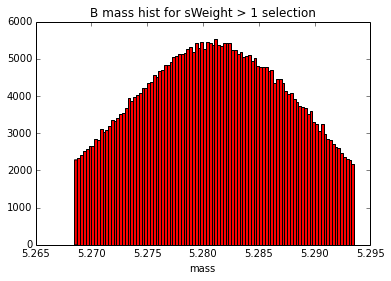

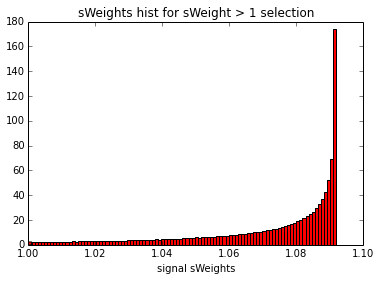

In [20]:
hist([gr['Bmass'].values[0] for _, gr in data_sw_pass.groupby('event')], bins=100)
title('B mass hist for sWeight > 1 selection')
xlabel('mass')
show()
hist([gr['N_sig_sw'].values[0] for _, gr in data_sw_pass.groupby('event')], bins=100, normed=True)
title('sWeights hist for sWeight > 1 selection')
xlabel('signal sWeights')
pass

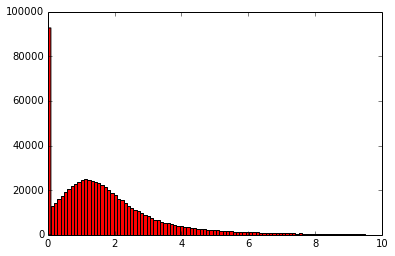

In [21]:
hist(data_sw_pass.diff_pt.values, bins=100)
pass

# Find good tracks to define sign B if you know track sign.

`label` = `signB` * `signTrack`
* the highest output means that this is same sign B as track
* the lowest output means that this is opposite sign B than track

## Define features

In [22]:
features = list(set(data.columns) - {'run', 'event', 'i', 'signB', 'signTrack', 'N_sig_sw', 'Bmass', 'mult', 
                                     'PIDNNp', 'PIDNNpi', 'label'})
features

['cos_diff_phi',
 'K_cut',
 'partPt',
 'partP',
 'nnkrec',
 'diff_eta',
 'EOverP',
 'mu_cut',
 'ptB',
 'e_cut',
 'PIDNNe',
 'PIDNNk',
 'PIDNNm',
 'proj',
 'phi',
 'diff_pt',
 'IP',
 'IPerr',
 'IPs',
 'ID',
 'veloch',
 'diff_phi',
 'ghostProb',
 'IPPU',
 'eta',
 'partlcs']

## PID pairs scatters

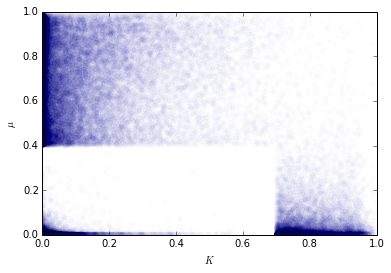

In [23]:
scatter(data_sw_pass['PIDNNk'].values, data_sw_pass['PIDNNm'].values, alpha=0.01)
xlabel('$K$')
ylabel('$\mu$')
ylim(0, 1)
xlim(0, 1)
pass

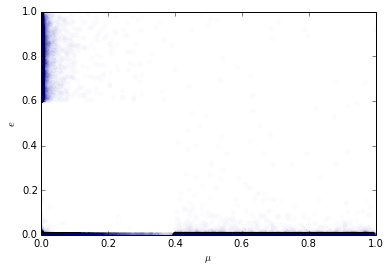

In [24]:
scatter(data_sw_pass['PIDNNm'].values, data_sw_pass['PIDNNe'].values, alpha=0.01)
xlabel('$\mu$')
ylabel('$e$')
ylim(0, 1)
xlim(0, 1)
pass

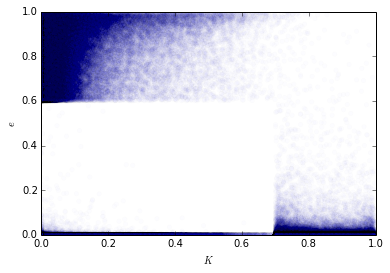

In [25]:
scatter(data_sw_pass['PIDNNk'].values, data_sw_pass['PIDNNe'].values, alpha=0.01)
xlabel('$K$')
ylabel('$e$')
ylim(0, 1)
xlim(0, 1)
pass

## pt

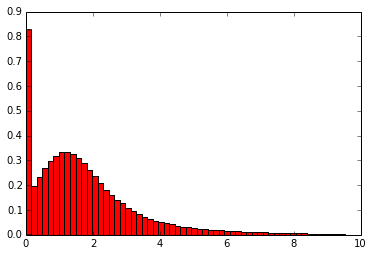

In [26]:
hist(data_sw_pass.diff_pt.values, bins=60, normed=True)
pass

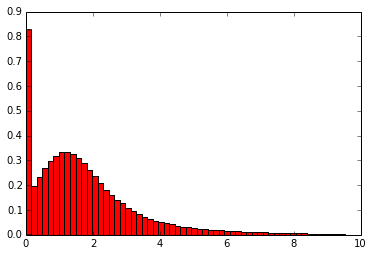

In [27]:
hist(data_sw_pass.diff_pt.values, bins=60, normed=True)
pass

## count of tracks

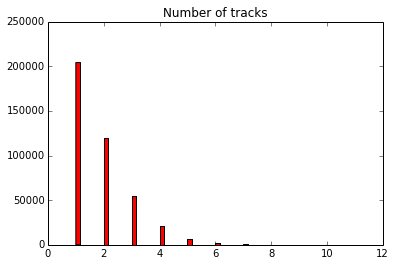

In [28]:
hist([len(gr) for num, gr in data_sw_pass.groupby('event')], bins=60)    
title('Number of tracks')
pass

## pids histograms

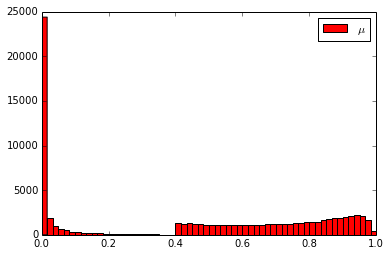

In [29]:
hist(data_sw_pass["PIDNNm"].values, bins=60, range=(0, 1), label='$\mu$')
legend()
pass

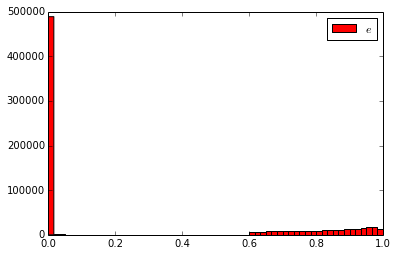

In [30]:
hist(data_sw_pass["PIDNNe"].values, bins=60, range=(0, 1), label='$e$')
legend()
pass

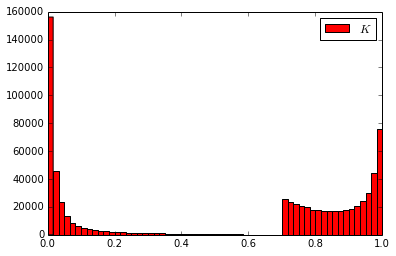

In [31]:
hist(data_sw_pass["PIDNNk"].values, bins=60, range=(0, 1), label='$K$')
legend()
pass

## 2-folding training selection tracks

In [32]:
base = RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=100, n_jobs=8)
est_choose_RT = FoldingClassifier(base, features=features)
%time est_choose_RT.fit(data_sw_pass, data_sw_pass.label, data_sw_pass.N_sig_sw)

CPU times: user 23min 32s, sys: 10.2 s, total: 23min 42s
Wall time: 23min 42s


FoldingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         features=['cos_diff_phi', 'K_cut', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'mu_cut', 'ptB', 'e_cut', 'PIDNNe', 'PIDNNk', 'PIDNNm', 'proj', 'phi', 'diff_pt', 'IP', 'IPerr', 'IPs', 'ID', 'veloch', 'diff_phi', 'ghostProb', 'IPPU', 'eta', 'partlcs'],
         ipc_profile=None, n_folds=2, random_state=None)

#### AUC

In [33]:
probs_RT = est_choose_RT.predict_proba(data_sw_pass)[:, 1]
roc_auc_score(data_sw_pass.label.values, probs_RT, sample_weight=data_sw_pass.N_sig_sw.values)

KFold prediction using folds column


0.54787443104625444

#### ROC

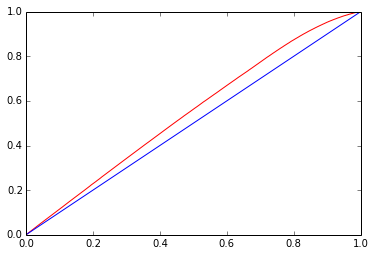

In [34]:
fpr, tpr, _ = roc_curve(data_sw_pass.label.values, probs_RT, sample_weight=data_sw_pass.N_sig_sw.values)
plot(fpr, tpr)
plot([0, 1], [0, 1])

In [35]:
imp = numpy.sum([est.feature_importances_ for est in est_choose_RT.estimators], axis=0)
pandas.DataFrame({'importance': -sort(-imp) / max(imp), 
                  'feature': numpy.array(est_choose_RT.features)[numpy.argsort(-imp)]})

,feature,importance
0,mu_cut,1.000000
1,K_cut,0.882316
2,IPs,0.745917
3,PIDNNm,0.647634
4,partPt,0.605379
5,IP,0.479287
6,diff_pt,0.419725
7,IPerr,0.369165
8,PIDNNk,0.328055
9,proj,0.318775


#### Distributions for output

In [36]:
%run utils.py

KFold prediction using folds column


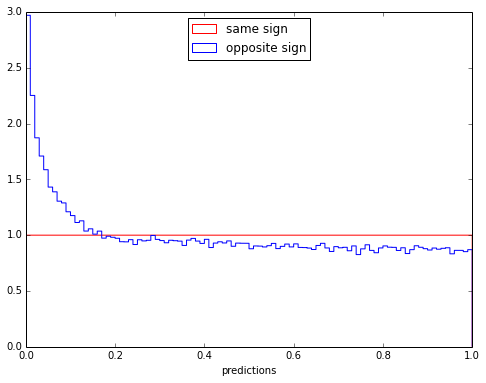

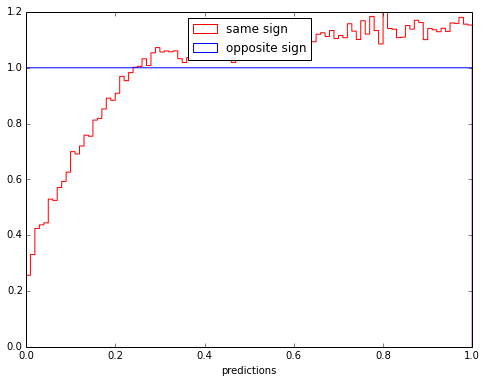

In [37]:
figsize(8, 6)
probs = est_choose_RT.predict_proba(data_sw_pass)
flat_ss = run_flat_probs(probs, data_sw_pass.label.values, data_sw_pass.N_sig_sw.values, label=1)
flat_os = run_flat_probs(probs, data_sw_pass.label.values, data_sw_pass.N_sig_sw.values, label=0)

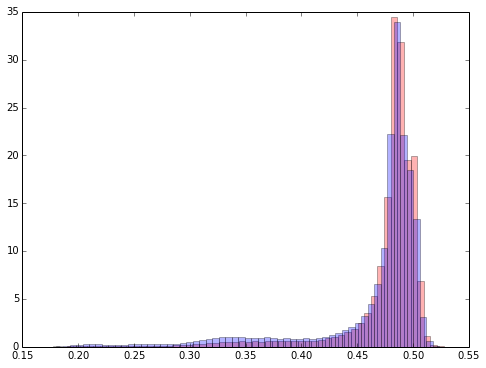

In [38]:
hist(probs[:, 1][data_sw_pass.label.values == 1], bins=60, alpha=0.3, normed=True)
hist(probs[:, 1][data_sw_pass.label.values == 0], bins=60, alpha=0.3, normed=True)
pass

#### Select top-good tracks in event

In [39]:
## select the better tracks by estimator in event (probability to be necessary sign)
def get_best_tracks(data, probs, count=1):
    train_prob = data.copy()
    train_prob.ix[train_prob.label == 1, 'prediction'] = probs[train_prob.label.values == 1]
    train_prob.ix[train_prob.label == 0, 'prediction'] = 1 - probs[train_prob.label.values == 0]
    
    add_tracks = []
    others = []
    for num, group in train_prob.groupby('event'):    
        index = numpy.argsort(group['prediction'].values)[::-1]
        add_tracks.append(group.iloc[index[:count], :])
        others.append(group.iloc[index[count:], :])
    good_tracks = pandas.concat(add_tracks)
    other_tracks = pandas.concat(others)
    print len(good_tracks), len(other_tracks)
    return good_tracks, other_tracks

In [40]:
## select same sign and oposite sign tracks simultaneously
def get_pair_best_tracks(data, probs, count=1):
    train_prob = data.copy()
    train_prob.ix[train_prob['label'] == 1, 'prediction'] = probs[train_prob['label'].values == 1]
    train_prob.ix[train_prob['label'] == 0, 'prediction'] = 1 - probs[train_prob['label'].values == 0]
    
    add_tracks = []
    others = []
    for num, group in train_prob.groupby('event'):    
        group_plus = group[group.label == 1]
        group_minus = group[group.label == 0]
    
        index = numpy.argsort(group_plus['prediction'].values)[::-1]
        add_tracks.append(group_plus.iloc[index[:count], :])
        others.append(group_plus.iloc[index[count:], :])
        index = numpy.argsort(group_minus['prediction'].values)[::-1]
        add_tracks.append(group_minus.iloc[index[:count], :])
        others.append(group_minus.iloc[index[count:], :])

    good_tracks = pandas.concat(add_tracks)
    other_tracks = pandas.concat(others)
    print len(good_tracks), len(other_tracks)
    return good_tracks, other_tracks

----

## Train to distinguish same sign vs opposite sign

In [41]:
from rep_ef.estimators import MatrixNetSkyGridClassifier
from hep_ml.decisiontrain import DecisionTrainClassifier
from hep_ml.losses import LogLossFunction

### TT

In [42]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=3000, depth=6, pretransform_needed=True, 
                                  max_features=10, loss=LogLossFunction(regularization=100))

In [43]:
tt_folding = FoldingClassifier(tt_base, n_folds=2, random_state=11, ipc_profile='ssh-ipy',
                               features=features)
%time tt_folding.fit(data_sw_pass, data_sw_pass.label, data_sw_pass.N_sig_sw.values)

CPU times: user 41 s, sys: 3.47 s, total: 44.5 s
Wall time: 6min 9s


FoldingClassifier(base_estimator=DecisionTrainClassifier(bootstrap=True, depth=6, learning_rate=0.02,
            loss=LogLossFunction(regularization=100), max_features=10,
            n_estimators=3000, pretransform_needed=True),
         features=['cos_diff_phi', 'K_cut', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'mu_cut', 'ptB', 'e_cut', 'PIDNNe', 'PIDNNk', 'PIDNNm', 'proj', 'phi', 'diff_pt', 'IP', 'IPerr', 'IPs', 'ID', 'veloch', 'diff_phi', 'ghostProb', 'IPPU', 'eta', 'partlcs'],
         ipc_profile='ssh-ipy', n_folds=2, random_state=11)

In [44]:
probs_RT = tt_folding.predict_proba(data_sw_pass)[:, 1]
roc_auc_score(data_sw_pass.label.values, probs_RT, sample_weight=data_sw_pass.N_sig_sw.values)

KFold prediction using folds column


0.54803079489515028

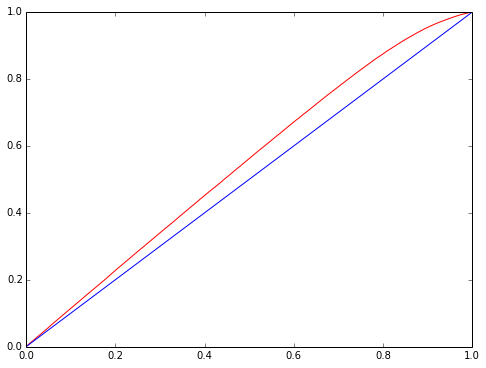

In [45]:
fpr, tpr, _ = roc_curve(data_sw_pass.label.values, probs_RT, sample_weight=data_sw_pass.N_sig_sw.values)
plot(fpr, tpr)
plot([0, 1], [0, 1])

In [46]:
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
report = ClassificationReport({'tt': tt_folding}, 
                              LabeledDataStorage(data_sw_pass, data_sw_pass.label.values, data_sw_pass.N_sig_sw.values))

KFold prediction using folds column


In [47]:
from rep.report.metrics import RocAuc
lc = report.learning_curve(RocAuc())

Default prediction


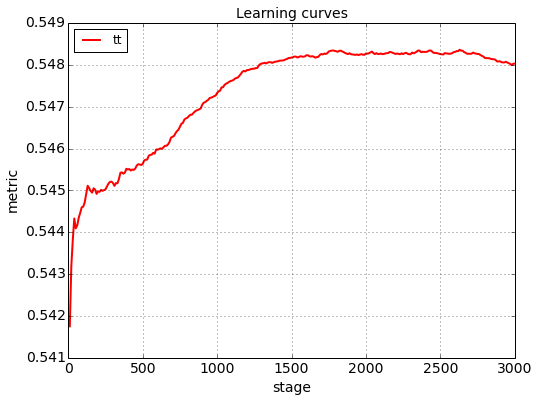

In [48]:
lc

### MN

In [51]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares', 
                                     iterations=1000, regularization=0.02, sync=True)
mn_folding = FoldingClassifier(mn_base, n_folds=2, random_state=11,
                               features=features)
%time mn_folding.fit(data_sw_pass, data_sw_pass.label, data_sw_pass.N_sig_sw.values)

CPU times: user 20.3 s, sys: 552 ms, total: 20.9 s
Wall time: 10min 53s


FoldingClassifier(base_estimator=MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals=64, iterations=1000, max_features_per_iteration=6,
              regularization=0.02, sync=True, train_features=None,
              training_fraction=0.5, user_name='antares'),
         features=['cos_diff_phi', 'K_cut', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'mu_cut', 'ptB', 'e_cut', 'PIDNNe', 'PIDNNk', 'PIDNNm', 'proj', 'phi', 'diff_pt', 'IP', 'IPerr', 'IPs', 'ID', 'veloch', 'diff_phi', 'ghostProb', 'IPPU', 'eta', 'partlcs'],
         ipc_profile=None, n_folds=2, random_state=11)

In [52]:
probs_RT = mn_folding.predict_proba(data_sw_pass)[:, 1]
roc_auc_score(data_sw_pass.label.values, probs_RT, sample_weight=data_sw_pass.N_sig_sw.values)

KFold prediction using folds column


0.54854198738952786

KFold prediction using folds column
Default prediction


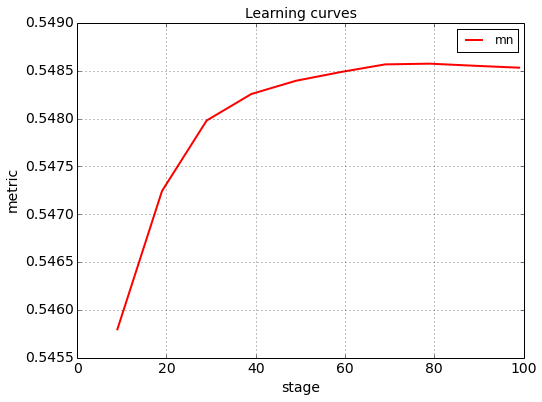

In [53]:
report = ClassificationReport({'mn': mn_folding}, 
                              LabeledDataStorage(data_sw_pass, data_sw_pass.label.values, data_sw_pass.N_sig_sw.values))
report.learning_curve(RocAuc())

In [54]:
imp = numpy.sum([est.feature_importances_ for est in mn_folding.estimators], axis=0)
pandas.DataFrame({'importance': -sort(-imp) / max(imp), 
                  'feature': numpy.array(mn_folding.features)[numpy.argsort(-imp)]})

,feature,importance
0,proj,1.000000
1,mu_cut,0.978454
2,K_cut,0.939865
3,IPs,0.875345
4,partPt,0.863239
5,PIDNNk,0.735351
6,IP,0.669772
7,diff_pt,0.663569
8,veloch,0.448539
9,IPPU,0.377475


---------

### Forest selection

In [55]:
temp_probs = est_choose_RT.predict_proba(data_sw_pass)[:, 1]
mask = ((flat_ss(temp_probs) < 0.6) & (data_sw_pass.label == 0)) | ((flat_os(temp_probs) > 0.4) & (data_sw_pass.label == 1))
data_sw_pass_rf_selected = data_sw_pass[mask]
data_sw_pass_rf_not_selected = data_sw_pass[~mask]

KFold prediction using folds column


In [56]:
statistics(data_sw_pass_rf_selected)

{'Events': 322812, 'tracks': 488890}

In [57]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=5000, regularization=0.02, sync=False)
mn_folding_forest = FoldingClassifier(mn_base, n_folds=2, random_state=11, 
                                      features=features)
mn_folding_forest.fit(data_sw_pass_rf_selected, data_sw_pass_rf_selected.label, 
                      data_sw_pass_rf_selected.N_sig_sw.values)

FoldingClassifier(base_estimator=MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals=64, iterations=5000, max_features_per_iteration=6,
              regularization=0.02, sync=False, train_features=None,
              training_fraction=0.5, user_name='antares'),
         features=['cos_diff_phi', 'K_cut', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'mu_cut', 'ptB', 'e_cut', 'PIDNNe', 'PIDNNk', 'PIDNNm', 'proj', 'phi', 'diff_pt', 'IP', 'IPerr', 'IPs', 'ID', 'veloch', 'diff_phi', 'ghostProb', 'IPPU', 'eta', 'partlcs'],
         ipc_profile=None, n_folds=2, random_state=11)

KFold prediction using folds column
Default prediction


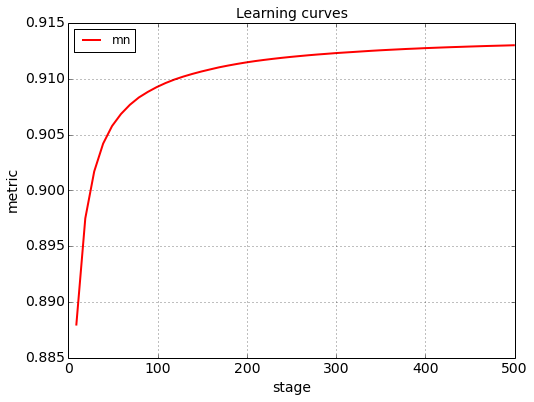

In [58]:
report = ClassificationReport({'mn': mn_folding_forest}, 
                              LabeledDataStorage(data_sw_pass_rf_selected, 
                                                 data_sw_pass_rf_selected.label.values,
                                                 data_sw_pass_rf_selected.N_sig_sw.values))
report.learning_curve(RocAuc())

----

### Top pair selection

In [59]:
temp_probs = est_choose_RT.predict_proba(data_sw_pass)[:, 1]
data_sw_pass_pair_selected, data_sw_pass_pair_not_selected = get_pair_best_tracks(data_sw_pass, temp_probs, count=1)

KFold prediction using folds column
542806 200270


In [60]:
print statistics(data_sw_pass_pair_selected)
print statistics(data_sw_pass_pair_not_selected)

{'tracks': 542806, 'Events': 409349}
{'tracks': 200270, 'Events': 142517}


In [61]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=2000, regularization=0.02, sync=False)
mn_folding_forest_top = FoldingClassifier(mn_base, n_folds=2, random_state=11, 
                                          features=features)
mn_folding_forest_top.fit(data_sw_pass_pair_selected, data_sw_pass_pair_selected.label, 
                          data_sw_pass_pair_selected.N_sig_sw.values)

FoldingClassifier(base_estimator=MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals=64, iterations=2000, max_features_per_iteration=6,
              regularization=0.02, sync=False, train_features=None,
              training_fraction=0.5, user_name='antares'),
         features=['cos_diff_phi', 'K_cut', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'mu_cut', 'ptB', 'e_cut', 'PIDNNe', 'PIDNNk', 'PIDNNm', 'proj', 'phi', 'diff_pt', 'IP', 'IPerr', 'IPs', 'ID', 'veloch', 'diff_phi', 'ghostProb', 'IPPU', 'eta', 'partlcs'],
         ipc_profile=None, n_folds=2, random_state=11)

KFold prediction using folds column
Default prediction


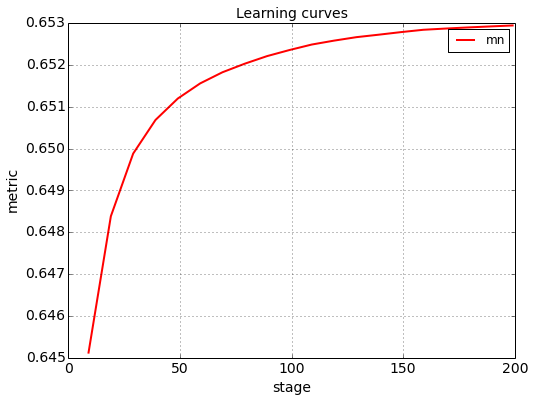

In [62]:
report = ClassificationReport({'mn': mn_folding_forest_top}, 
                              LabeledDataStorage(data_sw_pass_pair_selected, 
                                                 data_sw_pass_pair_selected.label.values,
                                                 data_sw_pass_pair_selected.N_sig_sw.values))
report.learning_curve(RocAuc())

--------

# Calibration

In [63]:
%run track_utils.ipynb

In [64]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
calib_track_iso = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
calib_track_log = LogisticRegression(C=100)

In [65]:
def run_calibration(eff_tag, eff_delta, est, datasets, est_calib, name, logistic=True, tag_selection=False):
    # Calibration p(track same sign|B)
    data_calib, track_probs, track_probs_calib = calibrate_track_prob(est, datasets, est_calib, 
                                                                      logistic=logistic, tag_selection=tag_selection)
    
    hist(track_probs[data_calib.label.values == 0], bins=60, normed=True, alpha=0.3, label='ss')
    hist(track_probs[data_calib.label.values == 1], bins=60, normed=True, alpha=0.3, label='os')
    legend(), title('track probs'), show()
    hist(track_probs_calib[data_calib.label.values == 0], bins=60, normed=True, alpha=0.3, label='ss')
    hist(track_probs_calib[data_calib.label.values == 1], bins=60, normed=True, alpha=0.3, label='os')
    legend(), title('track probs calibrated'), show()
    
    all_events = statistics(data_calib)['Events']
    assert all_events == statistics(data)['Events']
    
    # Compute p(B+)
    Bsign, Bweight, Bprob = compute_B_prob_using_track_prob(data_calib, track_probs_calib)
    
    hist(Bprob[numpy.array(Bsign) == 1], bins=60, normed=True, alpha=0.3, label='sign +')
    hist(Bprob[numpy.array(Bsign) == -1], bins=60, normed=True, alpha=0.3, label='sign -')
    legend(), title('B probs'), show()
    assert all_events == len(Bprob)
    
    # Compute p(B+) calibrated
    D2, alpha, aucs, iso_calibs = calibrate_B_prob(Bsign, Bweight, Bprob)
    print 'AUCs', numpy.mean(aucs), numpy.var(aucs)
    return D2, result_table(eff_tag, eff_delta, D2, name)

In [66]:
models = []

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


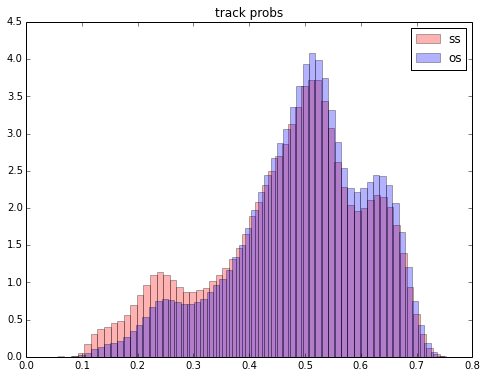

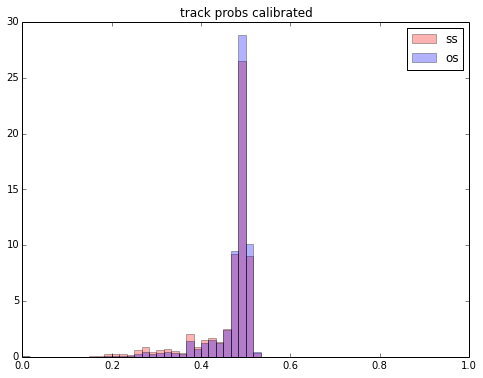

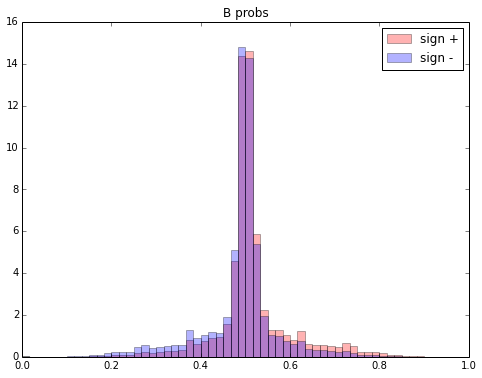

AUCs 0.58856256659 9.74159239142e-07


In [67]:
models.append(run_calibration(eff_tag, eff_delta, mn_folding_forest_top, 
                              [data_sw_pass_pair_selected, data_sw_pass_pair_not_selected, data_sw_not_pass], 
                              calib_track_iso, 'rt-top-mn-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


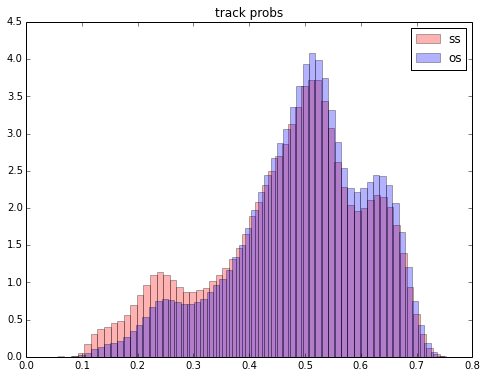

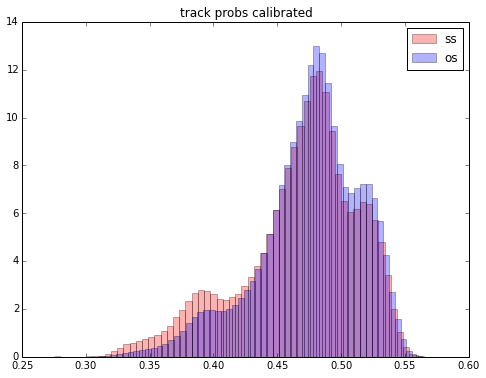

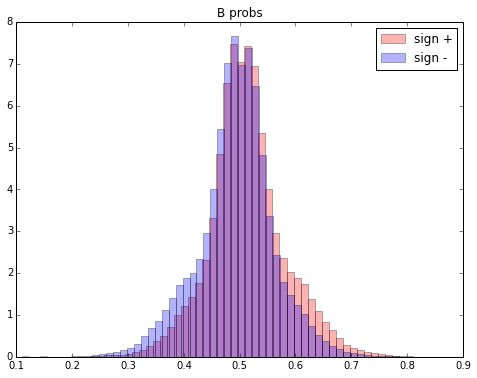

AUCs 0.586729230385 7.86207603259e-07


In [68]:
models.append(run_calibration(eff_tag, eff_delta, mn_folding_forest_top, 
                              [data_sw_pass_pair_selected, data_sw_pass_pair_not_selected, data_sw_not_pass], 
                              calib_track_log, 'rf-top-mn-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


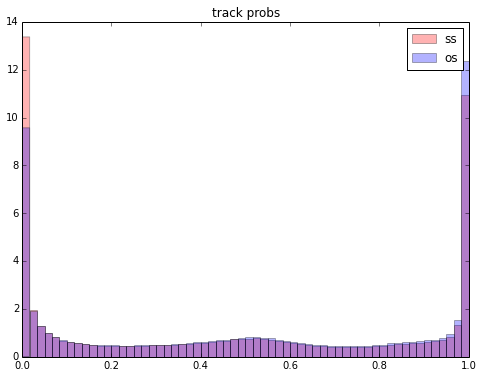

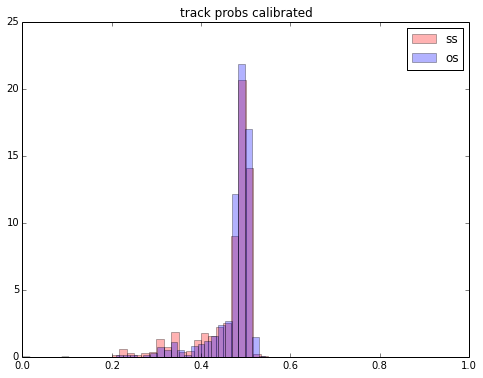

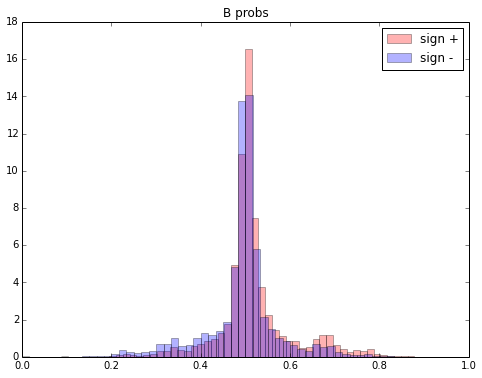

AUCs 0.588423308123 9.30071293427e-07


In [69]:
models.append(run_calibration(eff_tag, eff_delta, mn_folding_forest, 
                              [data_sw_pass_rf_selected, data_sw_pass_rf_not_selected, data_sw_not_pass], 
                              calib_track_iso, 'rf-mn-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


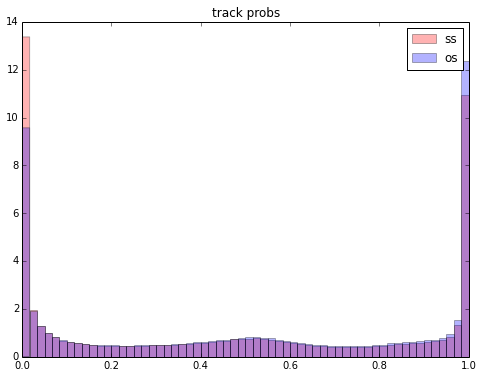

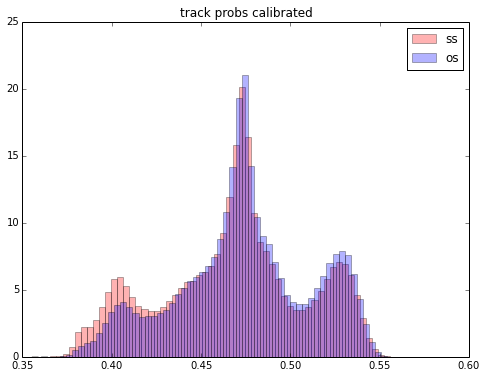

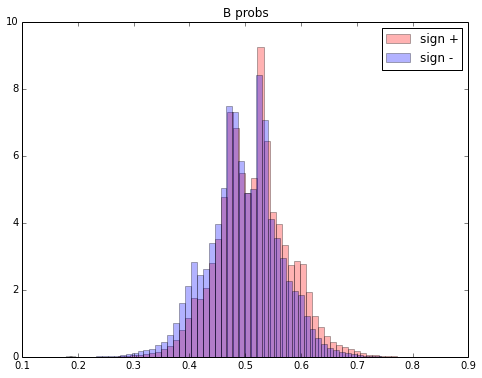

AUCs 0.584697230029 7.41097052468e-07


In [70]:
models.append(run_calibration(eff_tag, eff_delta, mn_folding_forest, 
                              [data_sw_pass_rf_selected, data_sw_pass_rf_not_selected, data_sw_not_pass], 
                              calib_track_log, 'rf-mn-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column


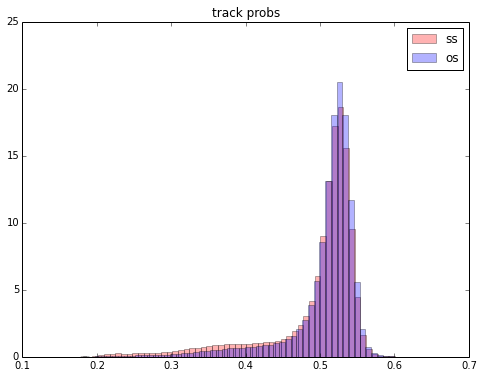

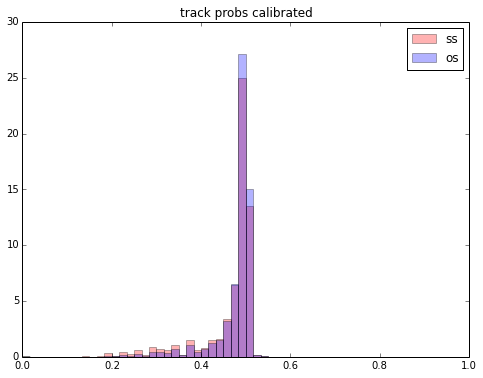

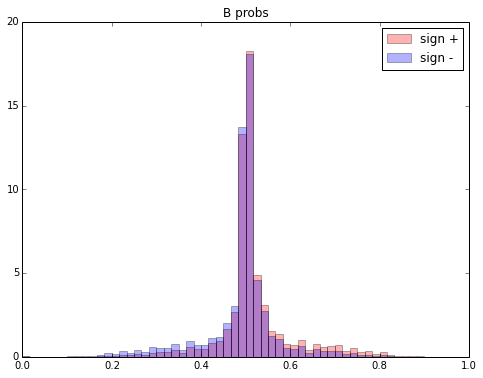

AUCs 0.587231704185 7.09334155343e-07


In [71]:
models.append(run_calibration(eff_tag, eff_delta, tt_folding, 
                              [data_sw_pass, data_sw_not_pass], calib_track_iso, 'tt-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column


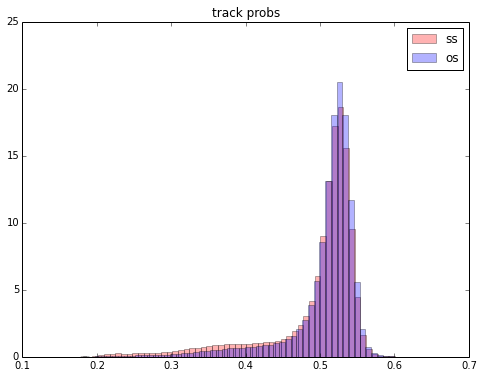

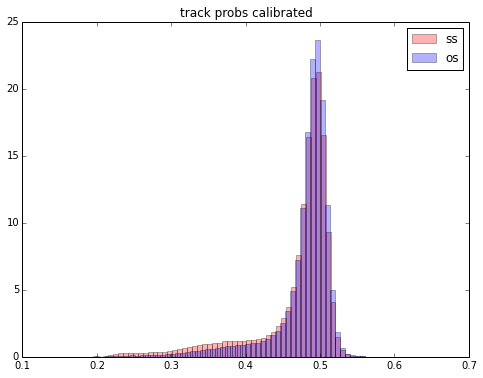

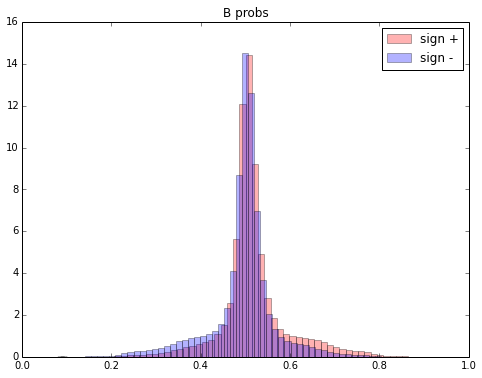

AUCs 0.587576269361 7.27026775329e-07


In [72]:
models.append(run_calibration(eff_tag, eff_delta, tt_folding, 
                              [data_sw_pass, data_sw_not_pass], calib_track_log, 'tt-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column


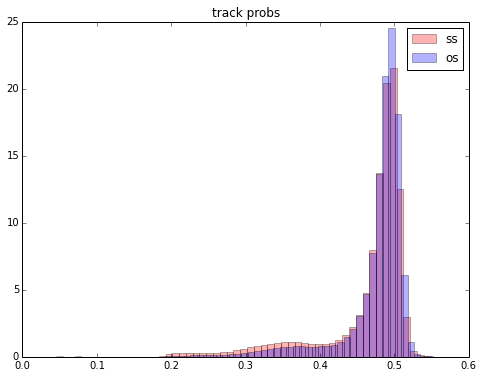

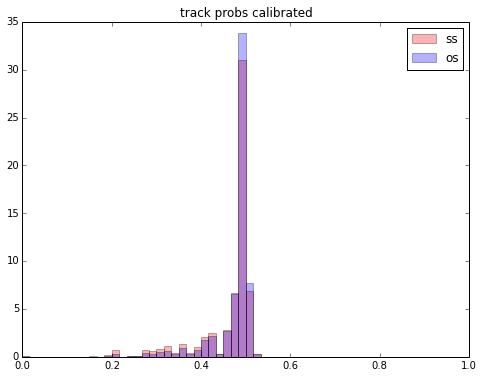

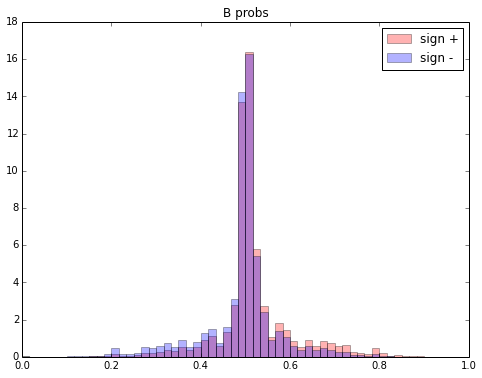

AUCs 0.587781644837 1.00645845435e-06


In [76]:
models.append(run_calibration(eff_tag, eff_delta, mn_folding, 
                              [data_sw_pass, data_sw_not_pass], calib_track_iso, 'mn-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column


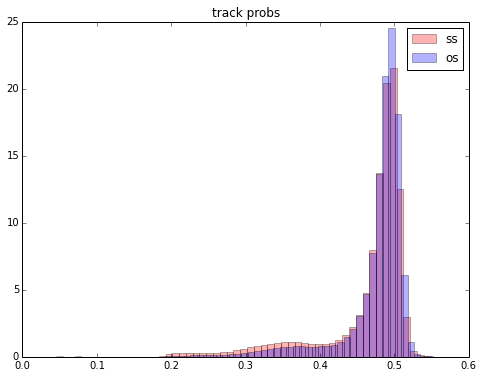

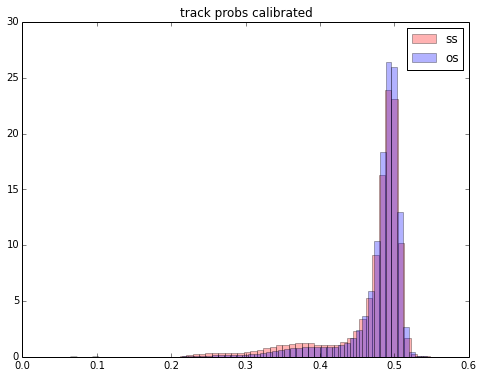

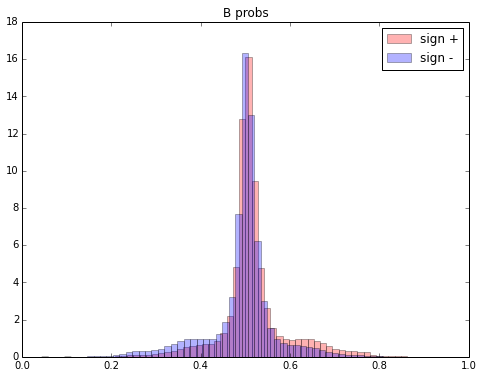

AUCs 0.588052363989 7.74671427036e-07


In [77]:
models.append(run_calibration(eff_tag, eff_delta, mn_folding, 
                              [data_sw_pass, data_sw_not_pass], calib_track_log, 'mn-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column


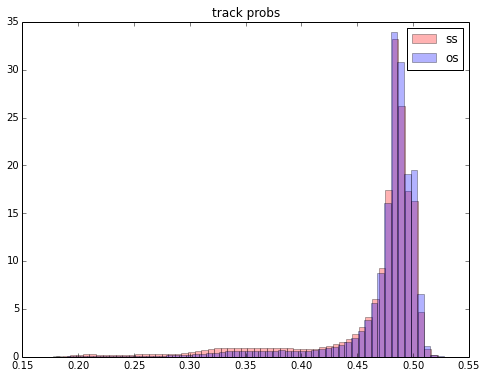

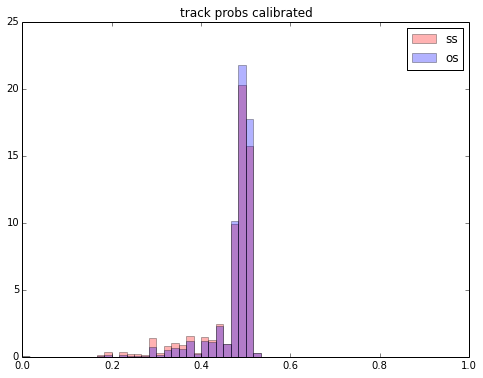

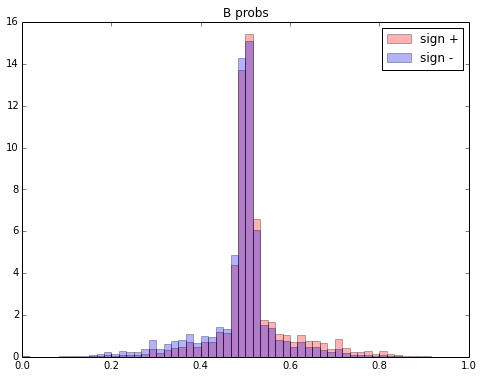

AUCs 0.587386859404 8.04951656592e-07


In [78]:
models.append(run_calibration(eff_tag, eff_delta, est_choose_RT, 
                              [data_sw_pass, data_sw_not_pass], calib_track_iso, 'rf-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column


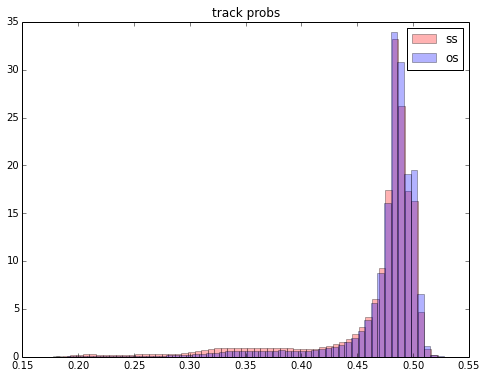

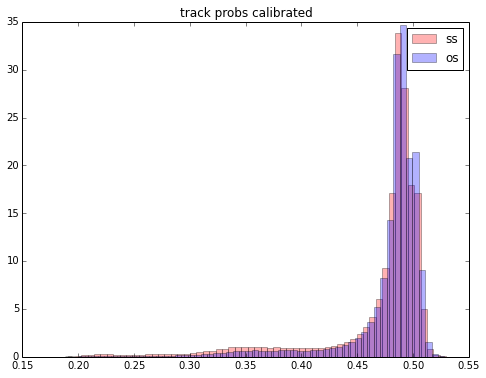

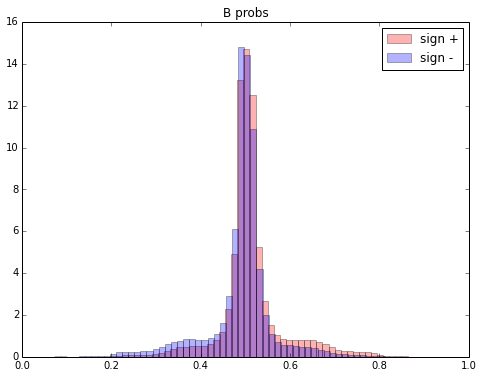

AUCs 0.587946924378 1.45359852749e-06


In [79]:
models.append(run_calibration(eff_tag, eff_delta, est_choose_RT, 
                              [data_sw_pass, data_sw_not_pass], calib_track_log, 'rf-log', logistic=True))

In [74]:
pandas.set_option('display.precision', 8)

In [80]:
result = pandas.concat([m for _, m in models])
result.index = result.name
result.drop('name', axis=1)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$"
name,,,,,,
rt-top-mn-iso,66.9607615,0.0949562,0.0281058,0.0000004,1.8819854,0.0026690
rf-top-mn-log,66.9607615,0.0949562,0.0286141,0.0000003,1.9160215,0.0027172
rf-mn-iso,66.9607615,0.0949562,0.0276701,0.0000005,1.8528117,0.0026277
rf-mn-log,66.9607615,0.0949562,0.0254226,0.0000001,1.7023138,0.0024140
tt-iso,66.9607615,0.0949562,0.0294663,0.0000004,1.9730880,0.0027981
tt-log,66.9607615,0.0949562,0.0321968,0.0000002,2.1559203,0.0030573
mn-iso,66.9607615,0.0949562,0.0285781,0.0000003,1.9136102,0.0027137
mn-log,66.9607615,0.0949562,0.0319886,0.0000002,2.1419825,0.0030375
rf-iso,66.9607615,0.0949562,0.0282510,0.0000006,1.8917080,0.0026829


In [295]:
result = pandas.concat([m for _, m in models])
result.index = result.name
result.drop('name', axis=1)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$"
name,,,,,,
rt-top-mn-iso,66.9607615,0.0949562,0.0278185,0.0000003,1.8627453,0.0026416
rf-top-mn-log,66.9607615,0.0949562,0.0287855,0.0000002,1.9275019,0.0027334
rf-mn-iso,66.9607615,0.0949562,0.0267305,0.0000003,1.7898945,0.0025383
rf-mn-log,66.9607615,0.0949562,0.0236073,0.0000002,1.5807599,0.0022417
tt-iso,66.9607615,0.0949562,0.0297664,0.0000004,1.9931803,0.0028266
tt-log,66.9607615,0.0949562,0.0325683,0.0000002,2.1807967,0.0030926
mn-iso,66.9607615,0.0949562,0.0295300,0.0000003,1.9773522,0.0028041
mn-log,66.9607615,0.0949562,0.0320949,0.0000002,2.1491011,0.0030476
rf-iso,66.9607615,0.0949562,0.0286112,0.0000003,1.9158286,0.0027169


In [314]:
temp_probs = est_choose_RT.predict_proba(data_sw_pass)[:, 1]
mask = ((flat_ss(temp_probs) < 0.6) | (flat_os(temp_probs) > 0.4))
data_sw_pass['tag'] = True
data_sw_pass.ix[~mask, 'tag'] = False

KFold prediction using folds column


/mnt/mfs/ipython_env/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  app.launch_new_instance()


In [ ]:
temp_probs = est_choose_RT.predict_proba(data_sw_not_pass)[:, 1]
mask = ((flat_ss(temp_probs) < 0.6) | (flat_os(temp_probs) > 0.4))
data_sw_not_pass['tag'] = True
data_sw_not_pass.ix[~mask, 'tag'] = False

In [301]:
temp = pandas.concat([data_sw_pass, data_sw_not_pass])
N_pass_rf = sum([gr['N_sig_sw'].values[0] for _, gr in temp[temp.tag].groupby('event')])
eff_tag_rf = 1. * N_pass_rf / N_all
eff_delta_rf = sqrt(N_pass_rf) / N_all
eff_tag_rf, eff_delta_rf

(0.66963831494404313, 0.00094958327919661563)

In [ ]:
models.append(run_calibration(eff_tag, eff_delta, mn_folding_forest, 
                              [data_sw_pass_rf_selected, data_sw_pass_rf_not_selected, data_sw_not_pass], 
                              calib_track_iso, 'rf cut + rf-mn-iso', logistic=False, tag_selection=True))

--------------------------

In [506]:
def compare_bins_iso(s=True):
    if s:
        a = numpy.linspace(0, 1, 100)
        label = 'uniform bins'
    else:
        a = numpy.percentile(p_train, numpy.linspace(0., 100, 100))
        a = numpy.array(list(a) + [1.])
        label = 'percentile bins'
    a = numpy.unique(a)
    bins_index = numpy.searchsorted(numpy.unique(a), p_train)
    n_sig = numpy.bincount(bins_index, (y_train > 0)*1, minlength=len(a) - 1)
    n_bck = numpy.bincount(bins_index, (y_train < 0)*1, minlength=len(a) - 1)
    p_bck = n_bck / (n_bck + n_sig)
    p_err = numpy.sqrt(n_sig * n_bck) / (n_sig + n_bck)**1.5
    errorbar((a[1:] - a[:-1]) / 2 + a[:-1], p_bck, xerr=(a[1:] - a[:-1]) / 2, yerr=p_err,  fmt='.', label=label)
    for i in range(1):
        plot(x, 1 - isos[i].transform(x), label='isotonic')
    ylim(0, 1)
    xlabel('BDT output', fontsize=16)
    ylabel('Probability to be wrong tagged', fontsize=16)
    legend()

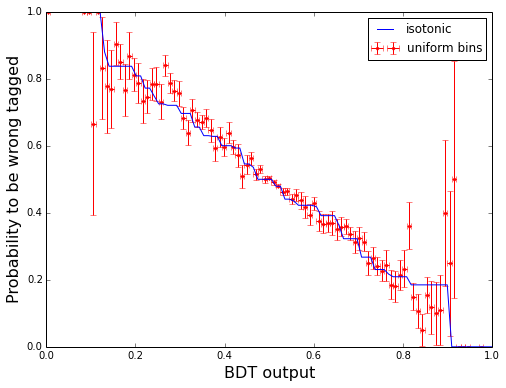

In [507]:
compare_bins_iso()

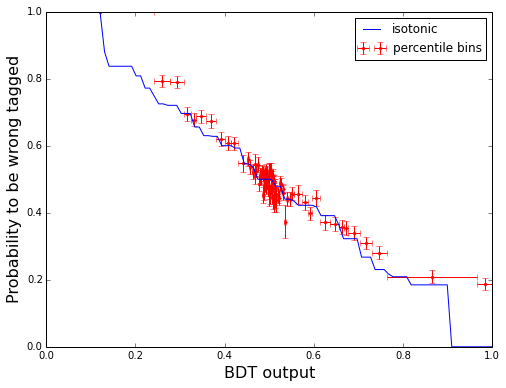

In [508]:
compare_bins_iso(False)

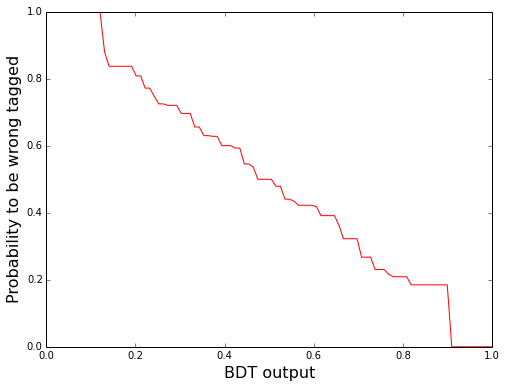

In [430]:
x = numpy.linspace(0, 1, 100)
for i in range(1):
    plot(x, 1 - isos[i].transform(x))
xlabel('BDT output', fontsize=16)
ylabel('Probability to be wrong tagged', fontsize=16)
legend()